# Database Exploration

By **Franklin Oliveira**

-----

This notebook contains some code written to I (Franklin) get accquainted with the `crustacea` database. Here you'll find some basic data treatment and adjustments that presented necessary as I started to understand the nature of the information in file <font color='blue'>'Planilha geral Atualizda FINAL com correções.xlsx'</font>.

In [1]:
import datetime
import numpy as np
import pandas as pd

from collections import defaultdict

# pacotes para visualização rápida
# import seaborn as sns
# import matplotlib.pyplot as plt

# Waffle Charts
from pywaffle import Waffle 
# docs: https://pywaffle.readthedocs.io/en/latest/examples/block_shape_distance_location_and_direction.html

# pacote para visualização principal
import altair as alt

# habilitando renderizador para notebook
alt.renderers.enable('notebook')

# desabilitando limite de linhas
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Importing data...

In [2]:
excel = pd.ExcelFile('Planilha geral Atualizda FINAL com correções.xlsx')
sheet_name = excel.sheet_names

print('The excel file contains the following sheets:', sheet_name)
print('\nDatabase is in sheet:', sheet_name[0])

The excel file contains the following sheets: ['Banco de Dados Colecao Carcinol', 'Planilha1']

Database is in sheet: Banco de Dados Colecao Carcinol


In [3]:
# db = excel.parse(sheet_name[0], sep=';', encoding='utf-8-sig')

# p.s.: I'm parsing a pre-treated file provided by Asla
db = pd.read_csv('db.csv', sep=',', encoding='utf-8-sig', low_memory=False)
print(f'The database has {db.shape[0]} rows and {db.shape[1]} columns.')

The database has 28689 rows and 132 columns.


In [4]:
# copying database to another variable to make a few changes keeping the original intact
crustaceas = db.copy()

<br>

### Name columns

`Determiner First Name1` e `Determiner Last Name1`

#### treating determiner's name 

In this step, we're going to put together determiner's first and last name. 

`Determiner First Name1` + `Determiner Last Name1`

Just concatenating those two columns is not satisfactory because there's some dirt in these data columns. So, let's begin by treating them...

In [5]:
def treat_names(name, pos='first'):
    '''
    Treat names keeping NaN as such.
    
    Arguments: 
        - name: name to be treated. 
        - pos (str): name position. One of ['first', 'last']
    '''
    if type(name) == str and pos == 'first':     # first name
        
        if len(name.split(' ')) > 1:             # treats composite names (+ 1 name)
            return str(name).strip().split(' ')[0].capitalize()
        else:
            return str(name).strip().capitalize()
    
    elif type(name) == str and pos == 'last':    # last name
        
        if len(name.split(' ')) > 1:             # treats composite last name (+ 1 surname)
            return str(name).strip().split(' ')[-1].capitalize()
        else:
            return str(name).strip().capitalize()   
    else:
        return name

applying function to the two column names

In [6]:
crustaceas['Determiner First Name1'] = crustaceas['Determiner First Name1'].apply(treat_names)
# crustaceas['Determiner First Name1'].value_counts()

In [7]:
crustaceas['Determiner Last Name1'] = crustaceas['Determiner Last Name1'].apply(lambda x:
                                                                treat_names(x, pos='last'))
# crustaceas['Determiner Last Name1'].value_counts()

In [8]:
# creating column with First and Last name for identification
crustaceas['Determiner First_and_Last Name'] = crustaceas['Determiner First Name1'] + ' ' + crustaceas['Determiner Last Name1']

<br>

## Adjusting columns names

### removing '\n'

In [9]:
crustaceas.columns = [str(col).replace(r'\n','') for col in crustaceas.columns]

#### closer look on some columns...

In [10]:
# crustaceas[['Species1', 'Species Author1', 'Type Status1', 'Qualifier1', 'Determiner First Name1',
#       'Determiner Middle1', 'Determiner Last Name1', 'Determined Date1']]

<br>

## preparing data for charts...

### Column: `Type Status1`

contains info on species type

In [11]:
crustaceas['Type Status1'].value_counts().head()

Paratipo    433
Holotipo    203
ParaTIPO    142
PARATIPO    120
HOLOTIPO     82
Name: Type Status1, dtype: int64

#### Let's begin cleaning this data and lowering all cases.

In [12]:
crustaceas['Type Status1'] = crustaceas['Type Status1'].str.strip().str.lower().str.capitalize()

In [13]:
crustaceas['Type Status1'].value_counts().head()

Paratipo         695
Holotipo         285
Alotipo           81
Topotipo           9
Paralectotipo      6
Name: Type Status1, dtype: int64

### preparing taxonomy columns

`Kingdom` - `Phylum1` - `Subphylum1` - `Class1` - `Subclass1` - `Infraclass1` - `Superorder1` - `Order1` - `Suborder1` - `Infraorder1` - `Superfamily1` - `Family1` - `Subfamily1` - `Tribe1` - `Genus1` - `Species1`

In [14]:
taxon_columns = crustaceas.columns[21:37]  # selecting taxonomy columns

# defining function
def treat_str(x):
    return str(x).lower().capitalize().strip()

# applying treatment
for col in taxon_columns:
    print(f'Adjusting column {col}')
    crustaceas[col] = crustaceas[col].apply(treat_str)

Adjusting column Kingdom
Adjusting column Phylum1
Adjusting column Subphylum1
Adjusting column Class1
Adjusting column Subclass1
Adjusting column Infraclass1
Adjusting column Superorder1
Adjusting column Order1
Adjusting column Suborder1
Adjusting column Infraorder1
Adjusting column Superfamily1
Adjusting column Family1
Adjusting column Subfamily1
Adjusting column Tribe1
Adjusting column Genus1
Adjusting column Species1


### adding `Genus1` and `Species1`together (they completely identify each animal's species)

In [16]:
crustaceas['genus_and_species'] = crustaceas['Genus1'] + ' ' + crustaceas['Species1']
crustaceas['genus_and_species'] = crustaceas['genus_and_species'].str.lower().str.capitalize()

<br>

### Collecting date (year) and sclicing main DB to a smaller dataset 

Columns: `Determined Date1` - `Class1` - `Kingdom` and more...

In [43]:
# slicing main database (crustaceas)
Table = crustaceas[['Cataloged Date','Determined Date1','Start Date','Class1','Kingdom', 
                    'Genus1', 'Species1', 'Type Status1',
                   'Determiner First_and_Last Name', 'Determiner First Name1',
                   'Determiner Last Name1', 'genus_and_species','Min Depth', 'Count 1',
                   'Species Author1', 'Order1', 'Suborder1', 'Infraorder1',
                   'Superfamily1', 'Family1', 'Subfamily1', 'Tribe1']].copy()

# OBS: Determined Date1 has many missing values... CHECK THAT
d = []
counter=0
for row in Table['Cataloged Date']:
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        if (month>1) and (month<12):
            #store the year and month in a datetime datatype for later sorting
            dateRecord = datetime.datetime(year,month,1)    
            
    d.append({'cataloged_year':year, 'count':Table.loc[counter,'Count 1'],
              'class':Table.loc[counter,'Class1'],
              'kingdom':Table.loc[counter,'Kingdom'], 'genus':Table.loc[counter,'Genus1'],
              'species':Table.loc[counter,'Species1'],
              'genus_and_species': Table.loc[counter,'genus_and_species'],
              'type_status':Table.loc[counter,'Type Status1'], 
              'determiner_first_and_last_name':Table.loc[counter,'Determiner First_and_Last Name'],
              'determiner_first_name':Table.loc[counter,'Determiner First Name1'],
              'determiner_last_name':Table.loc[counter,'Determiner Last Name1'],
              'depth':Table.loc[counter,'Min Depth'],
              'species_author':Table.loc[counter,'Species Author1'],
              'order':Table.loc[counter,'Order1'],
              'suborder':Table.loc[counter,'Suborder1'],
              'infraorder':Table.loc[counter, 'Infraorder1'],
              'superfamily':Table.loc[counter,'Superfamily1'],
              'family':Table.loc[counter,'Family1'],
              'subfamily':Table.loc[counter,'Subfamily1'],
              'tribe':Table.loc[counter,'Tribe1']
             })
    counter = counter+1

NewTable = pd.DataFrame(d)


### collecting determined year (p.s.: being careful to keep NaNs as they show up)
NewTable['determined_year'] = np.nan

d1 = []
counter=0
for row in Table['Determined Date1']:
    try:  # if Determined Date1 is empty, keep it so 
        if np.isnan(row):
            year= np.NAN
    
    except:
        if not str(row).find('/')==-1:
            dates_values = str(row).split("/")
            year = int(dates_values[0])
            month = int(dates_values[1])
            if (month>1) and (month<12):
                #store the year and month in a datetime datatype for later sorting
                dateRecord = datetime.datetime(year,month,1)    
    
    NewTable.loc[counter, 'determined_year'] = year
    counter = counter+1

    
### collecting start year (p.s.: being careful to keep NaNs as they show up)  
NewTable['start_year'] = np.nan
d1 = []
counter=0
for row in Table['Start Date']:
    try:  # if Start Date is empty, keep it so 
        if np.isnan(row):
            year= np.NAN
    
    except:
        if not str(row).find('/')==-1:
            dates_values = str(row).split("/")
            year = int(dates_values[0])
            month = int(dates_values[1])
            if (month>1) and (month<12):
                #store the year and month in a datetime datatype for later sorting
                dateRecord = datetime.datetime(year,month,1)    

    NewTable.loc[counter, 'start_year'] = year
    counter = counter+1

# NewTable['determined_year'] = pd.Series(year, index=NewTable.index)
NewTable.head(2)

,cataloged_year,count,class,kingdom,genus,species,genus_and_species,type_status,determiner_first_and_last_name,determiner_first_name,...,species_author,order,suborder,infraorder,superfamily,family,subfamily,tribe,determined_year,start_year
0,1980,5,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus schmitti,NaN,Alceu Castro,Alceu,...,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,NaN,1969.0
1,1980,15,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus schmitti,NaN,Alceu Castro,Alceu,...,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,NaN,NaN


In [44]:
# checks if NaNs are in the same position 
result = (NewTable['start_year'].isna() == crustaceas['Start Date'].isna()).sum() == NewTable.shape[0]

if result:
    print('Start year info is valid.')
else:
    print("There's something wrong with NewTable. Check how you're collecting Start Year info.")

Start year info is valid.


In [45]:
# year in which the holotipo was "firstly" found 
NewTable['holotipo_year'] = NewTable['species_author'].str.extract('(\d+)')

<br>

### creating `years` columns in crustaceas

In [47]:
def catch_year(row):
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        return year
    else:
        return np.NaN

In [48]:
crustaceas['determined_year'] = crustaceas['Determined Date1'].apply(catch_year)
crustaceas['start_year'] = crustaceas['Start Date'].apply(catch_year)
crustaceas['cataloged_year'] = crustaceas['Cataloged Date'].apply(catch_year)
crustaceas['holotipo_year'] = crustaceas['Species Author1'].str.extract('(\d+)')

<br>

---

## Graphs

### Total amount of catalogations per year

x: Start Year (from Start Date)
y: number of catalogations per year

In [53]:
# counting catalog. per year
teste = crustaceas['Start Date'].value_counts()
teste = teste.reset_index().rename(columns={'index':'year', 'Start Date':'counts'})

In [54]:
# adjusting columns for graphs
teste['year'] = teste['year'].apply(lambda x:x.split('/')[0]).astype(int)
teste = teste.groupby('year').sum().reset_index() # soma do total de bichos coletados por ano

In [55]:
# min e max para eixo X (year)
min_x = teste['year'].min()
max_x = teste['year'].max()

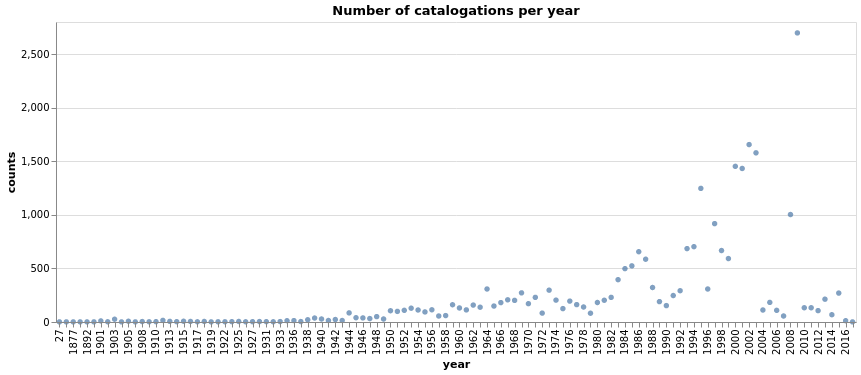

In [56]:
alt.Chart(data= teste, width=800, title= 'Number of catalogations per year').mark_circle().encode(
    x= alt.X('year', type='ordinal'),
    y= alt.Y('counts', type='quantitative')
)

<br>

### Types (*per year*)

x: Species1, cor: Type Status1, size: counts

#### adjusting columns `determined_year` e `cataloged_year` to ```*int*``` format 

In [57]:
def str_with_nan2int(string):
    if not np.isnan(string):
        return int(string)
    else:
        return np.NAN

In [61]:
NewTable['determined_year'] = NewTable['determined_year'].apply(str_with_nan2int) #has NaN
# NewTable['determined_year'] = NewTable['determined_year'].astype(int)
NewTable['cataloged_year'] = NewTable['cataloged_year'].astype(int)
NewTable['start_year'] = NewTable['start_year'].apply(str_with_nan2int) #has NaN

#### removing duplicated rows as we took a subset of the main database

In [89]:
teste1 = NewTable.drop_duplicates().copy()  # removes duplicated rows (with same values in ALL columns)
print('Duplicated registers:',NewTable.shape[0] - NewTable.drop_duplicates().shape[0])
# teste1.head(2)

Duplicated registers: 7001


#### sorting for y axis (researchers  are listed by their first year of contribution)

In [90]:
teste1.sort_values(['start_year','determiner_first_and_last_name'], inplace=True)

In [91]:
# names ordering for y axis
names_ordering = list(
    teste1[~teste1['determiner_first_and_last_name'].isna()]['determiner_first_and_last_name'].unique()
)

<br>

<font color='red' size='4'>**p.s.:** there are overlapping dots in the following graph. For each year, some researchers did catalog more than one *specimen* of different types. </font>

In [93]:
g1 = alt.Chart(teste1, width=800, height=2200).mark_circle().encode(
    x= alt.X('start_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status')
)

# # salvando o gráfico
# g1.save('./viz/1-determiner_and_year-null_name.svg')
# g1.save('./viz/1-determiner_and_year-null_name.html')

# g1

<br>

#### adjustements: removing empty names and types

In [95]:
g1 = alt.Chart(teste1[~teste1['determiner_first_and_last_name'].isna() & (~teste1['determined_year'].isna())],
               width=800, height=2200).mark_circle().encode(
    x= alt.X('start_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status')
)

# salvando o gráfico
# g1.save('./viz/2-determiner_and_year-null_type.svg')
# g1.save('./viz/2-determiner_and_year-null_type.html')

# g1

<br>

#### ordering per holotype year (year in which the holotype was discovered)

In [96]:
counts = teste1.groupby(['determiner_first_and_last_name', 'type_status','holotipo_year']).count()['class'].reset_index()
counts.rename(columns={'class':'counts'}, inplace=True)

In [97]:
teste1 = pd.merge(teste1, counts, on=['determiner_first_and_last_name', 'type_status','holotipo_year'])

In [98]:
teste1.sort_values(['holotipo_year','determiner_first_and_last_name', 'counts'], inplace=True)

In [99]:
# sorting order for y axis
names_ordering = list(
    teste1[(~teste1['determiner_first_and_last_name'].isna()) & (~teste1['type_status'].isna())]['determiner_first_and_last_name'].unique()
)

In [102]:
g1 = alt.Chart(teste1[(~teste1['determiner_first_and_last_name'].isna()) & (~teste1['type_status'].isna())],
               width=800, height=800).mark_circle().encode(
    x= alt.X('start_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status'),
#     size=alt.Size('depth')
)

# saving chart
# g1.save('./viz/2-determiner_and_year-cor.svg')
# g1.save('./viz/2-determiner_and_year-cor.html')

# g1

In [103]:
colors = ['#d62728', '#f58518', '#d95f02',
          '#d62729', '#f58519', '#d95f03',
          '#4daf4a', '#8c6d31',
          '#79706e', '#bab0ac', '#d8b5a5'
         ]

types = ['Holotipo', 'Alotipo', 'Neotipo',
          'Sintipo', 'Lectotipo', 'Paralectotipo',
          'Paratipo', 'Topotipo', 
          'Tipo', 'Co-tipo', 'Material tipo'
        ]

opacities= [1, 1, 1,
           0.4,0.4,0.4,
           1,1,1,
           1,1,1]

# creating dictionary with type:color
type_color = defaultdict()
for t in range(len(types)):
    type_color[types[t]] = colors[t] 

In [105]:
# p.s.: there are still overlapping points (it's affecting opacity)
g1 = alt.Chart(teste1[(~teste1['determiner_first_and_last_name'].isna()) & (~teste1['type_status'].isna())],
               width=800, height=800).mark_circle(size=60).encode(
    x= alt.X('start_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status', legend= alt.Legend(title='Type Status'),
                     sort=types,
                     scale= alt.Scale(domain=types,range=colors)
                  ),
    tooltip= alt.Tooltip(['determiner_first_and_last_name','determined_year','type_status','holotipo_year']),
    opacity= alt.Opacity(scale= alt.Scale(domain=types,range=opacities), type='quantitative')
#     size=alt.Size('depth')
)

# saving chart
# g1.save('./viz/2-determiner_and_year_ordered_per_holotype_discover_yr.svg')
# g1.save('./viz/2-determiner_and_year_ordered_per_holotype_discover_yr.html')

# g1

In [107]:
holotipo = teste1[(teste1['type_status'] == 'Holotipo')].copy()    # filtering just holotype
holotipo = holotipo[~holotipo['determiner_first_and_last_name'].isna()].copy() # making sure names are nonempty

# sorting
holotipo.sort_values('holotipo_year', inplace=True)

# sorting per holotipo year
names_ordering = list(holotipo['determiner_first_and_last_name'].values)

temp = holotipo.groupby(['order','start_year']).count()['count'].reset_index()

In [109]:
# New Chart
g1 = alt.Chart(holotipo,
               width=800, height=1200, title='Number of holotypes of each order per year').mark_circle(size=60,
                                                                                    color='red').encode(
    x= alt.X('start_year', type='ordinal', title='Determined Year'),
    y= alt.Y('genus_and_species', type='nominal', title='Species')
)

g2 = alt.Chart(holotipo,
               width=680, height=1200, title='Number of holotypes of each order per year').mark_circle(size=60,
                                                                                    color='blue').encode(
    x= alt.X('holotipo_year', type='ordinal', title='Holotype Year'),
    y= alt.Y('genus_and_species', type='nominal', title='Species')
)

# saving chart
# g1.save('./viz/holotypes_per_order.svg')
# g1.save('./viz/holotypes_per_order.html')

# g1 + g2

In [115]:
g1 = alt.Chart(temp[temp['order'] != 'Nan'],
               width=800, height=400, title='Number of holotypes of each order per year').mark_circle(size=60,
                                                                                color='red').encode(
    x= alt.X('start_year', type='ordinal', title='Year'),
    y= alt.Y('order', type='nominal', title='Order',
            sort= alt.EncodingSortField(field='count', op='max', order='descending')),
    size = alt.Size('count'),
)

# saving chart
# g1.save(f'./viz/types/holotypes_per_order.svg')
# g1.save(f'./viz/types/holotypes_per_order.html')

# g1

separating and grouping types

In [116]:
types = teste1['type_status'].unique()

group_types = []
for t in types:
    if t not in ['Holotipo', 'Alotipo', 'Paratipo']:
        group_types.append(t)

In [190]:
# replicating for all types
for t in ['Holotipo', 'Alotipo', 'Paratipo']:
    # preparing data
    temp1 = teste1[(teste1['type_status'] == t)].copy()                   # filtering just holotype
    temp = temp1[~temp1['determiner_first_and_last_name'].isna()].copy()  # making sure names are nonempty 
                                                                          
    # sorting
    temp.sort_values('holotipo_year', inplace=True)

    # sorting per holotipo year
    names_ordering = list(temp['determiner_first_and_last_name'].values)
    
    # grouping and counting per order and year
    temp = temp.groupby(['order','start_year']).count()['count'].reset_index()

    ### Chart
    g1 = alt.Chart(temp[temp['order'] != 'Nan'],
                   width=680, height=500, title=f'Number of {t} of each order per year').mark_circle(size=60,
                                                                     color=f'{type_color[t]}').encode(
        x= alt.X('start_year', type='ordinal', title='Year'),
        y= alt.Y('order', type='nominal', title='Order',
                sort= alt.EncodingSortField(field='count', op='count', order='descending')),
        size = alt.Size('count'),
    #     color= alt.Color('holotipo_year', type='quantitative', scale= alt.Scale(scheme='reds')), 
    #     opacity= alt.Opacity(scale= alt.Scale(domain=types,range=opacities), type='quantitative')
    #     size=alt.Size('depth')
    )

    # saving chart
#     g1.save(f'./viz/types/{t}_per_order.svg')
#     g1.save(f'./viz/types/{t}_per_order.html')

# g1

<br>

preparing data of other types to make a separate chart...

In [117]:
t = teste1['order'].unique()  # orders

In [118]:
temp = teste1[(teste1['order'] != 'Nan') & (teste1['type_status'].isin(group_types))]
temp = temp.groupby(['order','start_year','type_status']).count()['count'].reset_index()

colors = ['']

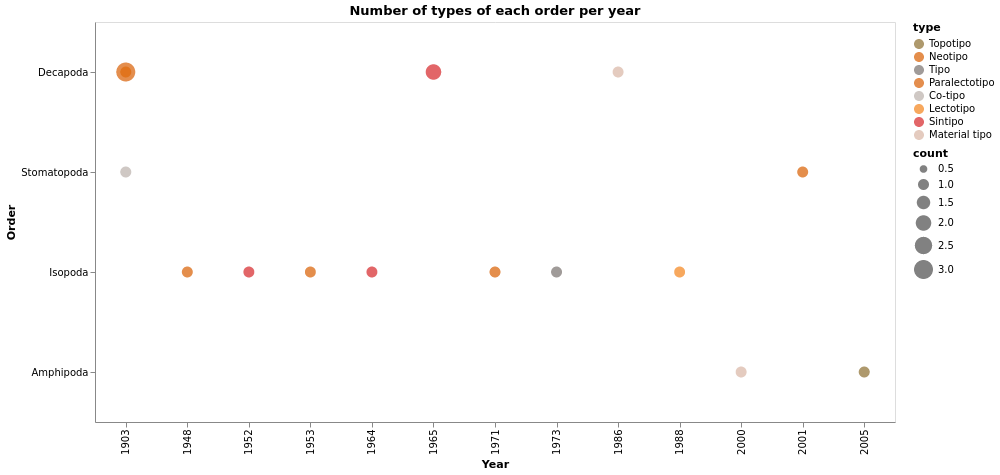

In [121]:
# making graph for other types (group_types)
g1 = alt.Chart(temp,
               width=800, height=400, title='Number of types of each order per year').mark_circle(
                                                                                size=60).encode(
    x= alt.X('start_year', type='ordinal', title='Year'),
    y= alt.Y('order', type='nominal', title='Order',
            sort= alt.EncodingSortField(field='count', op='max', order='descending')),
    color= alt.Color('type_status', title='type',
                     scale= alt.Scale(domain=group_types,range=[type_color[t] for t in group_types])),
    size = alt.Size('count', type='quantitative', scale = alt.Scale(type='bin-ordinal')),
)

# salvando o gráfico
# g1.save(f'./viz/types/other-types_per_order.svg')
# g1.save(f'./viz/types/other-types_per_order.html')

g1

### Next chart relates holotipo and start years

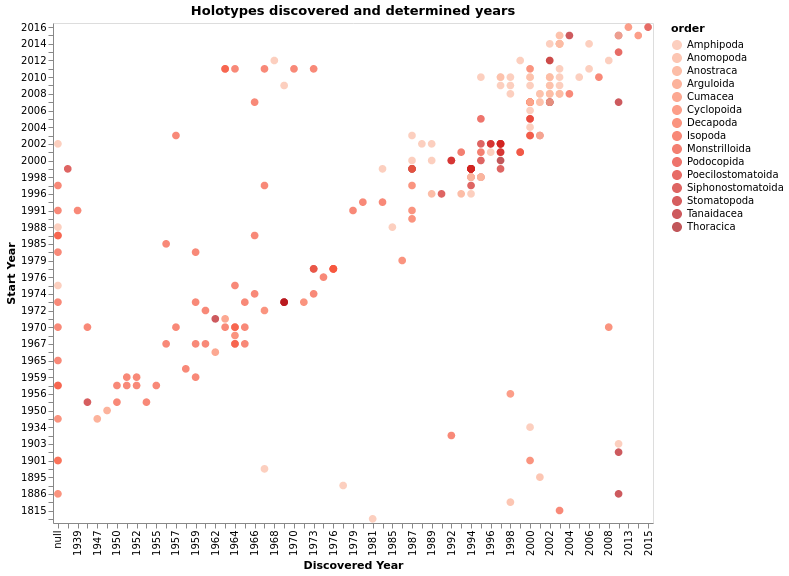

In [123]:
g1 = alt.Chart(holotipo, title='Holotypes discovered and determined years',
               width=600, height=500).mark_circle(size=60).encode(
    x= alt.X('start_year', type='ordinal', title='Start Year'),
    y= alt.Y('holotipo_year', type='ordinal', title='Holotipo Year',
            sort= alt.EncodingSortField(field='holotipo_year', order='descending')),
    tooltip= alt.Tooltip(['holotipo_year', 'start_year']),
    color= alt.Color('order', type='nominal', scale= alt.Scale(scheme='reds')), 
#     opacity= alt.Opacity(scale= alt.Scale(domain=types,range=opacities), type='quantitative')
#     size=alt.Size('depth')
)

# saving chart
# g1.save('./viz/types/holotipo_cataloged_and_determined_year.svg')
# g1.save('./viz/types/holotipo_cataloged_and_determined_year.html')

g1

### Número de catalogações de cad tipo (por ano)

In [ ]:
# teste1 é construída a partir do df NewTable
type_data = teste1.groupby(['type_status','year']).count()['class'].reset_index().rename(
                                                    columns={'class':'counts'})

In [ ]:
type_data.sort_values(['counts'], inplace=True)

<font color='red' size='5'>**Anotar valores nas células**</font>

In [ ]:
g3 = alt.Chart(type_data, title='Number of animals of each type per year').mark_rect().encode(
    x= alt.X('year', type='ordinal', title='Year'),
    y= alt.Y('type_status', type='nominal', title='Type', 
             sort=alt.EncodingSortField(field="counts", op="mean", order='descending'),
            axis=alt.Axis(grid=False)),
    color= alt.Color('counts', type='quantitative', scale=alt.Scale(scheme='yellowgreenblue'))
)

g3.save('./viz/types_per_year.html')
g3.save('./viz/types_per_year.svg')

g3

<br>

**Thats it!**

-----